Here, we are trying to predict the future log return distribution based on financial statements.

In [161]:
import sqlite3
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

conn = sqlite3.connect('C:/Users/Siwoo/PycharmProjects/ValuatorV2/database/valuator.db')

Adjust the following parameters to tweak the pipeline

In [162]:
param = {}  # a dict that stores all the parameter values

param["date_begin"] = datetime.datetime(2010, 1, 1)  # earliest of the whole data
param["val_split_point"] = datetime.datetime(2020, 1, 1)  # valid date begins with this date
param["date_end"] = datetime.datetime(2023, 12, 1)  # latest of the whole data

# preprocessing steps for x (financial statements)
param["TTM"] = False  # uses trailing twelve months average data instead of raw
param["adjust_price_w_CPI"] = True  # allows adjusting prices with CPI data
param["apply_asset_constraint"] = False  # allows applying the asset constraint (asset = equity + liability)
param["apply_nonnegative_constraint"] = False  # deletes rows where their supposedly non-negative columns have negative column values
param["divide_by_total_assets"] = True  # divide the relevant columns with total assets to diminish multicolinearity

param["prune_outlier"] = False  # prune outlier
param["Winsorize"] = True
param["outlier_quantile"] = 0.999  # cutoff value determined by quantile. 0.99 means keep 99% of the values
param["outlier_thresh"] = 2  # rows up to this many outlier value will survive

#preprocessing steps for y (close)
param["adjust_using_SPY"] = True  # use market-adjusted log returns instead of regular returns. Removes any market-induced movements
param["window_length"] = 365  # days forward to calculate mean (or std) log returns
param["min_periods"] = 120  # minimum days needed to calculate the mean (or std) log returns
param["transform_to_cls"] = False  # transforms the problem into classification problem (return > 0 or not)



In [163]:
df = pd.read_sql("""
SELECT * FROM bic
WHERE symbol in
    (SELECT symbol FROM profiles
    WHERE country = "US"
    AND isFund = 0
    AND isEtf = 0
    AND currency = "USD"
    AND (exchangeShortName = "NASDAQ" OR exchangeShortName = "NYSE"))
    AND symbol NOT LIKE '%W'
ORDER BY symbol, date ASC
""", con=conn)

macro_df = pd.read_sql("""
SELECT * FROM macro_US
""", con=conn)

cursor = conn.execute("""SELECT * FROM balance""")
balance_columns = [description[0] for description in cursor.description]

cursor = conn.execute("""SELECT * FROM income""")
income_columns = [description[0] for description in cursor.description]

cursor = conn.execute("""SELECT * FROM cashflow""")
cashflow_columns = [description[0] for description in cursor.description]

In [164]:
df['fillingDate'] = pd.to_datetime(df['fillingDate'])
df['date'] = pd.to_datetime(df['date'])
macro_df['date'] = pd.to_datetime(macro_df['date'])
CPI_base = macro_df[macro_df['date'] == param["val_split_point"]]['CPI'].values
macro_df['CPI'] = macro_df['CPI'] / CPI_base

In [165]:
df = df.merge(macro_df, how="left", on="date")
df = df.set_index(['symbol', 'fillingDate'])
df = df.drop(columns=['date', 'reportedCurrency'])

In [166]:
balance_ignored_features = ['goodwillAndIntangibleAssets',
                            'totalLiabilitiesAndStockholdersEquity',
                            'netDebt',
                            'cashAndShortTermInvestments']
income_ignored_features = ['grossProfitRatio',
                           'costAndExpenses',
                           'EBITDARatio',
                           'operatingIncomeRatio',
                           'incomeBeforeTaxRatio',
                           'netIncomeRatio',
                           'EPSDiluted',
                           'weightedAverageShsOut',
                           'weightedAverageShsOutDil',
                           'interestIncome']
cashflow_ignored_features = []  # nothing yet
macro_ignored_features = ['realGDP', "consumerSentiment", "smoothedUSRecessionProbabilities"]

In [167]:
df = df.drop(
    columns=balance_ignored_features + income_ignored_features + cashflow_ignored_features + macro_ignored_features)

In [168]:
other_dropped_columns = []
for column in df.columns:
    if "other" in str(column).lower() or "1" in str(column).lower():
        other_dropped_columns.append(column)
df = df.drop(columns=other_dropped_columns)
print(df.columns)

Index(['deferredRevenue', 'commonStock', 'cashAndCashEquivalents',
       'minorityInterest', 'totalNonCurrentAssets', 'changeInWorkingCapital',
       'inventory', 'deferredTaxLiabilitiesNonCurrent', 'freeCashFlow',
       'accountsReceivables', 'shortTermDebt', 'intangibleAssets',
       'capitalLeaseObligations', 'acquisitionsNet',
       'deferrredTaxLiabilitiesNonCurrent', 'goodwill',
       'netCashUsedForInvestingActivites', 'preferredStock', 'grossProfit',
       'taxAssets', 'capitalExpenditure', 'accountPayables',
       'totalCurrentLiabilities', 'cashAtEndOfPeriod',
       'totalStockholdersEquity', 'operatingIncome', 'totalDebt',
       'netCashProvidedByOperatingActivites', 'netChangeInCash', 'EBITDA',
       'revenue', 'salesMaturitiesOfInvestments', 'deferredRevenueNonCurrent',
       'totalLiabilities', 'retainedEarnings', 'stockBasedCompensation',
       'longTermInvestments', 'shortTermInvestments', 'commonStockRepurchased',
       'purchasesOfInvestments', 'totalCur

Adjust price level using CPI

In [169]:
if param["adjust_price_w_CPI"]:
    df['federalFunds'] = df['federalFunds'] * df['CPI']
    df = df.divide(df['CPI'], axis=0)
df = df.drop(columns='CPI')

Visualization: the following code reorders columns so that they are grouped by their financial statement types(balance/income/cashflow) for better visualization

In [170]:
def reorder_dataframe(df, column_order):
    """
    Reorders a DataFrame based on a given list of column names.

    :param df: pandas DataFrame
    :param column_order: List of column names to order the DataFrame by
    :return: Reordered DataFrame
    """
    # Remove duplicates while preserving order
    seen = set()
    unique_column_order = [col for col in column_order if col not in seen and not seen.add(col)]

    # Filter out columns that are not in the DataFrame
    valid_columns = [col for col in unique_column_order if col in df.columns]

    extra_columns = [col for col in df.columns if col not in valid_columns]

    # Reorder the DataFrame
    reordered_df = df[valid_columns + extra_columns]

    return reordered_df

In [171]:
df = reorder_dataframe(df, balance_columns + income_columns + cashflow_columns)

In [172]:
# TTM script
if param["TTM"]:
    df_TTM = df.groupby(level=0).rolling(4, min_periods=4).mean().droplevel(0)
    df = df_TTM  # I know this one is useless, but I felt like adding this

drop rows with nulls

In [173]:
df = df.dropna(axis=0, how="any")
print(df.isna().sum())

cashAndCashEquivalents              0
shortTermInvestments                0
netReceivables                      0
inventory                           0
totalCurrentAssets                  0
                                   ..
operatingCashFlow                   0
capitalExpenditure                  0
freeCashFlow                        0
deferredTaxLiabilitiesNonCurrent    0
federalFunds                        0
Length: 68, dtype: int64


Preprocessing: removes any rows that do not satisfy the asset constraint
asset constraint:
equity + liability = asset
current asset + noncurrent asset = total asset

In [174]:
if param["apply_asset_constraint"]:
    asset_current_mask = np.abs((df['totalCurrentAssets'] + df['totalNonCurrentAssets']) / df['totalAssets']) < 1.001
    asset_total_mask = np.abs((df['totalStockholdersEquity'] + df['totalLiabilities']) / df['totalAssets']) < 1.001
    mask = np.logical_and(asset_total_mask, asset_current_mask)
    df = df[mask]

Preprocessing: The following code removes any rows with invalid data--for example, total asset shouldn't be negative. Done by deleting rows where nonnegative constriant columns have negative values. the nonnegative constraint columns are chosen by finding columns that only have less than 1% of negative values.

In [175]:
if param["apply_nonnegative_constraint"]:
    nonnegative_constraint_columns = []
    for column in df.columns:
        if df[column].min() < 0 and np.sum(df[column] < 0) < 0.01 * len(df):
            print(column)
            print(np.sum(df[column] < 0), "/", len(df))
            nonnegative_constraint_columns.append(column)

    for column in nonnegative_constraint_columns:
        df = df[df[column] >= 0]

Preprocessing: divides all money-related columns with total asset and log transforms total asset.

In [176]:
if param["divide_by_total_assets"]:
    df = df[df['totalAssets'] > 0]
    unaffected_cols = ['federalFunds', 'totalAssets']
    affected_cols = [col for col in df.columns if col not in unaffected_cols]
    df[affected_cols] = df[affected_cols].div(df['totalAssets'], axis=0)
    df['totalAssets'] = np.log(df['totalAssets'])

Visualization: check correlation matrix to see correlations between features

In [177]:
def find_correlated_pairs(df, threshold=0.5):
    """
    Finds all pairs of columns in a DataFrame that have a correlation
    greater than a specified threshold or less than the negative of that threshold.

    :param df: pandas DataFrame
    :param threshold: correlation threshold
    :return: list of tuples with the pairs of correlated columns
    """
    correlated_pairs = []

    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Iterate over each element in the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

    return correlated_pairs

In [178]:
import networkx as nx


def plot_correlation_network(df, threshold=0.5):
    """
    Plots a 2D correlation network from the correlation matrix of a DataFrame.

    :param df: pandas DataFrame
    :param threshold: correlation threshold for including an edge in the network
    """
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Create a graph
    G = nx.Graph()

    # Add nodes
    for column in corr_matrix.columns:
        G.add_node(column)

    # Add edges
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                G.add_edge(corr_matrix.columns[i], corr_matrix.columns[j], weight=corr_matrix.iloc[i, j])

    # Draw the network
    pos = nx.spring_layout(G)  # positions for all nodes
    edges = G.edges(data=True)
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", alpha=0.7,
            width=[(1 + abs(d['weight'])) * 0.5 for u, v, d in edges],
            edge_color=[("red" if d['weight'] < 0 else "green") for u, v, d in edges])

    plt.title("Correlation Network")
    plt.show()

In [179]:
# corr_pairs = find_correlated_pairs(df)
# plot_correlation_network(df, threshold=0.3)

visualization: see histogram

In [180]:
def plot_histogram_with_pruning(dataframe, column, q=0.99):
    """
    Plots a histogram of a DataFrame column while pruning out the top and bottom 1% of the distribution.

    :param dataframe: pandas DataFrame
    :param column: column name (string) whose distribution to plot
    :param q: quantile
    """
    # Ensure the column exists in the DataFrame
    if column not in dataframe.columns:
        print(f"Column '{column}' not found in DataFrame.")
        return

    # Prune the top and bottom of the data

    if df[column].min() >= 0:
        upper_bound = dataframe[column].quantile(q)
        pruned_data = dataframe[column][dataframe[column] <= upper_bound]
    else:
        lower_bound = dataframe[column].quantile(1 - q)
        upper_bound = dataframe[column].quantile(q)
        pruned_data = dataframe[column][(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]

    # Plot histogram
    plt.hist(pruned_data, bins=100, log=True)
    plt.title(f"Histogram of '{column}' ({(1 - q) * 100}% Pruned)")
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


In [181]:
# for col in df.columns:
#     plot_histogram_with_pruning(df, col, q=0.99)

Load price data from the DB

In [182]:
close_prices = pd.read_sql(f"""
SELECT date, symbol, close
FROM cv
WHERE symbol in (SELECT symbol FROM profiles
    WHERE country = "US"
    AND isFund = 0
    AND isEtf = 0
    AND currency = "USD"
    AND (exchangeShortName = "NASDAQ" OR exchangeShortName = "NYSE"))
    AND date BETWEEN date('{param["date_begin"].strftime("%Y-%m-%d")}') AND date('{param["date_end"].strftime("%Y-%m-%d")}')
""", con=conn, index_col=["symbol", "date"])

Unstack it

In [183]:
close_prices = close_prices['close'].unstack(level=0)

In [184]:
spy = pd.read_sql(f"""
SELECT date, symbol, close
FROM cv
WHERE symbol = "SPY" AND date BETWEEN date('{param["date_begin"].strftime("%Y-%m-%d")}') AND date('{param["date_end"].strftime("%Y-%m-%d")}')
""", con=conn, index_col=["symbol", "date"])

In [185]:
spy = spy["close"].unstack(level=0)

In [186]:
close_prices = pd.merge(close_prices, spy, "left", on='date')

In [187]:
close_prices[
    close_prices <= 0] = pd.NA  # turn any nonpositive numbers to Null values. We can't have negative price in stocks!
close_prices = close_prices.dropna(how='all', axis=1)  # now drop all symbols that have no values at all
close_prices = np.log(close_prices)  # apply log to every value
close_prices = close_prices.diff()  # calculate difference

Parameter: log return -> market adjusted log return

In [188]:
if param["adjust_using_SPY"]:
    close_prices = close_prices.subtract(close_prices["SPY"], axis=0)

Parameter: forward window=365(days)

In [189]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=param["window_length"])
close_prices_mean = close_prices.rolling(window=indexer,
                                         min_periods=param["min_periods"]).mean()
# survivorship bias warning, this may nullify all delisted companies
close_prices_mean = close_prices_mean * 365  # annualize the data

In [190]:
close_prices_mean.index = pd.to_datetime(close_prices_mean.index)
close_prices = close_prices_mean.stack()
close_prices.name = "close"

In [191]:
df_ready = df.merge(close_prices, how='inner', left_index=True, right_on=['symbol', 'date'])
df_ready = df_ready.dropna(axis=0, how="any")
df_ready = df_ready.swaplevel(0, 1, axis=0)

Parameter: classification, or regression?

In [192]:
if param["transform_to_cls"]:
    df_ready["close"] = df_ready["close"] >= 0

In [193]:
train_mask = df_ready.index.get_level_values('date') < (
            param["val_split_point"] - datetime.timedelta(days=param["window_length"]))
valid_mask = df_ready.index.get_level_values('date') > param["val_split_point"]
train = df_ready.loc[train_mask]
valid = df_ready.loc[valid_mask]

Preprocessing: outlier pruning

In [194]:
class Winsorizer:
    def __init__(self):
        self.column_quantiles = []
        self.is_fitted = False

    def fit(self, dataframe, exclude_columns, q=0.99):
        for col in dataframe.columns:
            if col not in exclude_columns:
                if dataframe[col].min() >= 0:
                    lower_bound = -1
                    upper_bound = dataframe[col].quantile(q)
                else:
                    lower_bound = dataframe[col].quantile(1 - q)
                    upper_bound = dataframe[col].quantile(q)
                self.column_quantiles.append((col, lower_bound, upper_bound))
        self.is_fitted = True

    def transform(self, dataframe):
        if self.is_fitted:
            for col, lower, upper in self.column_quantiles:
                dataframe.loc[:, col] = np.clip(dataframe[col], lower, upper)
            return dataframe
        else:
            raise Exception("cannot transform before fitting.")

class OutlierPruner:
    def __init__(self):
        self.column_quantiles = []

    def fit(self, dataframe, exclude_columns, q=0.99):
        for col in dataframe.columns:
            if col not in exclude_columns:
                if dataframe[col].min() >= 0:
                    lower_bound = -1
                    upper_bound = dataframe[col].quantile(q)
                else:
                    lower_bound = dataframe[col].quantile(1 - q)
                    upper_bound = dataframe[col].quantile(q)
                self.column_quantiles.append((col, lower_bound, upper_bound))

    def transform(self, dataframe, thresh=0):
        counter = 0
        m_total = pd.Series(0, index=dataframe.index, name="total mask")
        for col, lower, upper in self.column_quantiles:
            m_total += ((dataframe[col] >= lower) & (dataframe[col] <= upper))
            counter += 1
        mask = m_total >= counter - thresh
        return dataframe[mask]

In [195]:
if param["prune_outlier"]:
    pruner = OutlierPruner()

    print("shape before pruning:", train.shape, valid.shape)
    pruner.fit(train, ['federalFunds', 'close'], q=param["outlier_quantile"])
    train = pruner.transform(train, thresh=param["outlier_thresh"])
    valid = pruner.transform(valid, thresh=param["outlier_thresh"])
    print("shape after pruning:", train.shape, valid.shape)

if param["Winsorize"]:
    pruner = Winsorizer()
    pruner.fit(train, ['federalFunds'], q=param["outlier_quantile"])
    train = pruner.transform(train)
    valid = pruner.transform(valid)
    print("shape after pruning:", train.shape, valid.shape)

shape after pruning: (95377, 69) (65331, 69)


In [196]:
train_x, train_y = train.drop(columns="close").to_numpy(), train["close"].to_numpy()
valid_x, valid_y = valid.drop(columns="close").to_numpy(), valid["close"].to_numpy()

In [197]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(eta=0.01, device='cuda', objective='reg:pseudohubererror', early_stopping_rounds=30,
                             max_bin=512, n_estimators=300, missing=np.inf)
xgb_model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)],)

[0]	validation_0-mphe:0.18841
[1]	validation_0-mphe:0.18821
[2]	validation_0-mphe:0.18802
[3]	validation_0-mphe:0.18783
[4]	validation_0-mphe:0.18764
[5]	validation_0-mphe:0.18746
[6]	validation_0-mphe:0.18729
[7]	validation_0-mphe:0.18711
[8]	validation_0-mphe:0.18694
[9]	validation_0-mphe:0.18677
[10]	validation_0-mphe:0.18660
[11]	validation_0-mphe:0.18644
[12]	validation_0-mphe:0.18627
[13]	validation_0-mphe:0.18611
[14]	validation_0-mphe:0.18595
[15]	validation_0-mphe:0.18580
[16]	validation_0-mphe:0.18567
[17]	validation_0-mphe:0.18552
[18]	validation_0-mphe:0.18538
[19]	validation_0-mphe:0.18524
[20]	validation_0-mphe:0.18510
[21]	validation_0-mphe:0.18496
[22]	validation_0-mphe:0.18482
[23]	validation_0-mphe:0.18468
[24]	validation_0-mphe:0.18455
[25]	validation_0-mphe:0.18442
[26]	validation_0-mphe:0.18431
[27]	validation_0-mphe:0.18417
[28]	validation_0-mphe:0.18405
[29]	validation_0-mphe:0.18394
[30]	validation_0-mphe:0.18382
[31]	validation_0-mphe:0.18369
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=30,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=512, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=inf,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

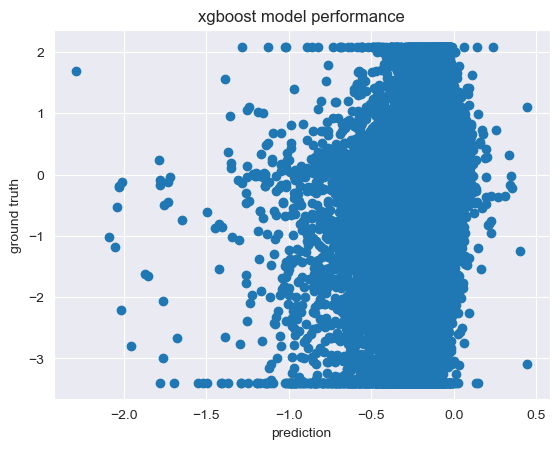

r and p for return prediction: 0.3239455966553401 0.0


In [198]:
import scipy
valid_pred = xgb_model.predict(valid_x)
plt.scatter(valid_pred, valid_y)
plt.ylabel("ground truth")
plt.xlabel("prediction")
plt.title("xgboost model performance")
plt.show()
ret_r, ret_p = scipy.stats.pearsonr(valid_pred, valid_y)
print("r and p for return prediction:", ret_r, ret_p)

In [199]:
  # from ngboost import NGBRegressor

# ngb_model = NGBRegressor(learning_rate=0.01, minibatch_frac=0.3, verbose_eval=10)
# ngb_model.fit(train_x, train_y, X_val=valid_x, Y_val=valid_y, early_stopping_rounds=30)

In [200]:
# %matplotlib inline
#
# valid_pred = ngb_model.predict(valid_x)
# plt.scatter(valid_pred, valid_y)
# plt.ylabel("ground truth")
# plt.xlabel("prediction")
# plt.title("ngboost model performance")
# plt.show()
# ret_r, ret_p = scipy.stats.pearsonr(valid_pred, valid_y)
# print("r and p for return prediction:", ret_r, ret_p)

In [201]:
# %matplotlib tk
#
# valid_pred_dist = ngb_model.pred_dist(valid_x)
# new_valid_pred = []
# new_valid_y = []
# for i in range(len(valid_y)):
#     if valid_pred_dist.loc[i] - 0.3 * valid_pred_dist.scale[i] > 0:
#         new_valid_pred.append(valid_pred_dist.loc[i])
#         new_valid_y.append(valid_y[i])
#
# plt.scatter(new_valid_pred, new_valid_y)
# plt.ylabel("ground truth")
# plt.xlabel("prediction")
# plt.title("ngboost model performance")
# plt.show()
# ret_r, ret_p = scipy.stats.pearsonr(new_valid_pred, new_valid_y)
# print("r and p for return prediction:", ret_r, ret_p)